# Homework 3: Dimensionality Reduction and Model Selection

Follow the instructions in the template, score will be given uppon it.
<br>Some basic rules:
- Use only relative path (like it is written in the template). if You need to use a different path, don't forget to revert it to original before submitting
- Code must run without errors.
- It is encouraged to check yourself with outputs such as prints, plots etc. Remember to delete extra outputs before submitting.

## Import libraries
You are allowed to use these libraries only.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from typing import List, Dict
%matplotlib inline

# Part 1: Dimensionality Reduction

## Load & external data

In this part we shall use the 'crime_data' data set. about this data: [UCI Repository](https://archive.ics.uci.edu/ml/datasets/communities+and+crime#:~:text=UCI%20Machine%20Learning%20Repository%3A%20Communities%20and%20Crime%20Data%20Set&text=Abstract%3A%20Communities%20within%20the%20United,from%20the%201995%20FBI%20UCR.) </br><br>
The following code loads the data, and splits it to train and test for this exercise. </br>
</br>
It also normalizes the data for as follows:</br>
PCA needs each column to have zero mean. In addition, it works better when all features share the same variance (common shoice is 1). the sklearn transformer StandardScaler does exactly that.

In [2]:
# load
data = pd.read_csv("crime_data.csv")

#Converting data to numpy arrays
X, y = data.values[:,:-1], data.values[:, -1]
print(f'X.shape: {X.shape}, y.shape: {y.shape}')

#split to train and test
X_train_raw ,X_test_raw ,y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state= 42, shuffle=True)
print(f'X_train_raw.shape: {X_train_raw.shape}, y_train.shape: {y_train.shape}, \
X_test_raw.shape: {X_test_raw.shape}, y_test.shape: {y_test.shape}')

# normalize to have 0 mean and 1 variance (according to train distribution)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
print(f'X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}')

X.shape: (1994, 103), y.shape: (1994,)
X_train_raw.shape: (1595, 103), y_train.shape: (1595,), X_test_raw.shape: (399, 103), y_test.shape: (399,)
X_train.shape: (1595, 103), X_test.shape: (399, 103)


## a. PCA 
 - Implement the function get_principal_components. The function returns the minimal group of components, which explain more than (100*p)% of the variance.
 - Use the next cell to print the number of minimal number of components explaining at least 99% of X_train

In [3]:
# Import Package
from sklearn.decomposition import PCA

In [4]:
def get_principal_components(X: np.array, p: float) -> np.array:
    """
    Returns array of principal components explaining (100*p)% of the variance
    X: 2d numpy array of data we want to apply PCA on. 
    p: float in the range (0,1]. The proportion of variance explained by components
    """
    return PCA(n_components=p, whiten=True).fit(X).components_



In [5]:
components = get_principal_components(X_train,0.99)
print(f'number of components which preserve at least 99% of the variance: {len(components)}')

number of components which preserve at least 99% of the variance: 60


## b. Forward Selection
In this section we will implement a forward selection algorithm, using linear regression and Mallows cp penalization. </br> 
**Reminder:** <br><br>
$ C_p= MSE+2\frac{d+1}{n}\hat{\sigma}^2$ <br><br>
Where : $ \hat{\sigma}^2 = \frac{RSS_{all features}}{n-\#features-1} $,   and $\#features$ is the number of all features

### b1. implement the noise variance estimation
implement the function get_sigma_hat_squared function which retrieves the estimate of sigma_hat_squared. <br>

In [6]:
def get_sigma_hat_squared(X: np.array, y: np.array) -> float:
    """
    Returns sigma_hat squared - an estimate of the noise variance sigma
    X: 2d np.array with the data.
    y: labels
    return: float - the sigma hat squared.
    """
    model = LinearRegression()
    predictions = model.fit(X,y).predict(X)
    rss = sum(((y - predictions)**2))
    sigma_hat = rss / (X.shape[0] - X.shape[1] - 1)
    return sigma_hat


### b2. implement the mallows C_p scoring
implement the function get_mallows_cp_score which retrieves the mallows Cp score for linear regression. <br>

In [7]:
def get_mallows_cp_score(X: np.array ,y: np.array, sigma_hat_squared: float) -> float:
    """
    Returns mallow cp score for given data, selected features and train model.
    X: 2d numpy array of data with only selected features
    y: 1d numpy array of labels (also knows as target values)
    sigma_hat_squared: the estimate for noise variance
    """
    model = LinearRegression()
    predictions = model.fit(X,y).predict(X)
    n = len(X)
    d = len(X[1])
    mse = mean_squared_error(y_true=y, y_pred=predictions)

    cp_score = mse + 2*((d+1)/n)*sigma_hat_squared
    return cp_score


### b3. Implement comparison function
Create a function that gets as input a list of features and returns the best feature to add

In [8]:
def add_feature(X: np.array ,y: np.array ,current_features: List[int] , sigma_hat_squared: float) -> Dict:
    """
    Returns dictionary with list of features including chosen feature to include and the score with selected feature
    X: 2d np array with all the features.
    y: 1d np array with the labels
    current_features: list of indexes which represent the features which are already included
    sigma_hat_squared: the estimate for noise variance
    returns: A dictionary with 2 keys:
            'features': a sorted list of indexes containing the features of the best model (with the additional feature) -> current_features + [added feature]
            'score': the mallows cp score of that model
    """
    
    best_features_lst = None
    best_score = 100000
    
    non_chosen_features = [i for i in range(X.shape[1]) if i not in current_features]
    for feature in non_chosen_features:
            features_tested = current_features + [feature]
            current_X = X[:, features_tested] 
            current_score = get_mallows_cp_score(current_X,y, sigma_hat_squared)
            if best_score > current_score:
                     best_score = current_score
                     best_features_lst = features_tested

    return {'features':sorted(best_features_lst),'score':best_score}  

### b3. Forward selection wrapper
No need to implement anying here. When all previous functions are implemented, you should get a nice graph of the mallows C_p score w.r.t the number of features, and print number of features which were chosen

In [9]:
def forward_selection(X: np.array, y: np.array) -> List[int]:
    """
    returns list of indexes for the selected features
    X: 2d numpy array with original training data
    y: numpy vector with targets of training data
    returns: a sorted list containing the indexes of the selected features
    """
    num_of_features = X.shape[1]
    current_features = []
    # Calculate error on model with all features
    sigma_hat_squared = get_sigma_hat_squared(X, y)

    models_lst = []
    for i in range(num_of_features):
        res = add_feature(X,y,current_features,sigma_hat_squared)
        models_lst.append(res)
        current_features = models_lst[-1]['features']
    
    #Plotting
    scores_lst = [x['score'] for x in models_lst]
    plt.plot(range(1,len(scores_lst)+1),scores_lst)
    plt.xlabel("number of features")
    plt.ylabel("Mallows cp")
    plt.title("Mallows Cp score VS number of features")
    plt.show()

    #Returning features of best model, based on mcp score
    best_model = min(models_lst, key = lambda x: x['score'])
    best_features = best_model['features']
    return sorted(best_features)

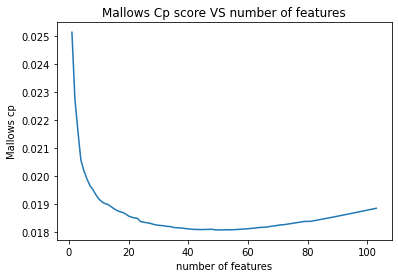

number of selected features by forward: 52


In [10]:
res = forward_selection(X_train,y_train)
print(f'number of selected features by forward: {len(res)}')

## C. Comparison

In the next section, we use the previous results to form new train and test sets

In [11]:
# calculate the test MSE for each reduced dataset
x_forward_reduced_train = X_train[:,res]
x_forward_reduced_test = X_test[:,res]

# get components based on train set:
train_components = get_principal_components(X_train,0.99)
x_pca_train = np.dot(X_train, train_components.T)
x_pca_test = np.dot(X_test, train_components.T)

### C1. Results
Using these new datasets, print the train mse & test mse of each model, and answer the question briefly

In [12]:
model_forward = LinearRegression()
model_forward.fit(x_forward_reduced_train, y_train)
test_mse_forward = mean_squared_error(y_test, model_forward.predict(x_forward_reduced_test))

model_pca = LinearRegression()
model_pca.fit(x_pca_train, y_train)
test_mse_pca = mean_squared_error(y_test, model_pca.predict(x_pca_test))

train_mse_forward =   mean_squared_error(y_train, model_forward.predict(x_forward_reduced_train))
train_mse_pca =  mean_squared_error(y_train, model_pca.predict(x_pca_train))

print(f'MSE train - PCA: {round(train_mse_pca,4)}')
print(f'MSE test - PCA: {round(test_mse_pca,4)}')
print(f'MSE train - forward: {round(train_mse_forward,4)}')
print(f'MSE test - forward: {round(test_mse_forward,4)}')

MSE train - PCA: 0.0177
MSE test - PCA: 0.018
MSE train - forward: 0.0169
MSE test - forward: 0.0173


### C2. Answer below: 
Based on the results shown above and what you know, which way is better to reduce dimensionality in this case? forward with Mallows Cp, or PCA with 0.99?

Answer: 
     PCA can be very effective (and cheaper in computations) but can also reduce buisness understanding.
     this is why, when results are similar between PCA and Forward (like in our case), It is better to choose forward.

# Part 2

The following code downloads the MNIST data set (one of the most common data set in machine learning).<br>
It contains images of hand written digits in gray scale. The training data contains 60,000 images (6,000 from each digit), and 10,000 test set. Each image is a 28X28 pixel image (total of 784 pixels).<br>
a few examples:<br><br>
<img src="https://storage.googleapis.com/tfds-data/visualization/fig/mnist-3.0.1.png" width="200"/>
<br>In this exercise we shall classify the digits 0 and 8. The following code downloads the data set and splits it to train  and test. The labels are changed to 0 (for 0) and 1 (for 8)

In [13]:
data, labels = fetch_openml('mnist_784', version=1, return_X_y=True)
neg, pos = '0', '8'

In [14]:
# Take data with 0 or 8 digits only and make labels 0 or 1 accordingly
binary_df = data[(labels==neg)|(labels==pos)]
binary_label = labels[(labels==neg)|(labels==pos)]
binary_label.replace({neg:0,pos:1},inplace=True)

# Convert to numpy array
X_digits = binary_df.values
y_digits = binary_label.ravel() #we don't use values becasue data is multi-labeled

In [15]:
train_and_validation_data,test_data,train_and_validation_labels,test_labels = train_test_split(X_digits,y_digits,
                                                        test_size = 0.25,
                                                        random_state= 42, 
                                                        shuffle=True,
                                                        stratify = y_digits)

#stratify means keeping equal proportions of labels in train and test

In [16]:
# spliting train to - train and validation
train_data,validation_data ,train_labels,validation_labels = train_test_split(train_and_validation_data,train_and_validation_labels,
                                                        test_size = 0.2,
                                                        random_state= 42, 
                                                        shuffle=True)

In [17]:
train_labels = train_labels.astype('int')
validation_labels = validation_labels.astype('int')
train_and_validation_labels = train_and_validation_labels.astype('int')
test_labels = test_labels.astype('int')


In [18]:
print('Train dimensions:')
print(f'data: {train_data.shape}')
print(f'labels: {train_labels.shape}')

print('validation dimensions:')
print(f'data: {validation_data.shape}')
print(f'labels: {validation_labels.shape}')

print('Test dimensions:')
print(f'data: {test_data.shape}')
print(f'labels{test_labels.shape}')

Train dimensions:
data: (8236, 784)
labels: (8236,)
validation dimensions:
data: (2060, 784)
labels: (2060,)
Test dimensions:
data: (3432, 784)
labels(3432,)


## To visualize a digit, we can use the following code

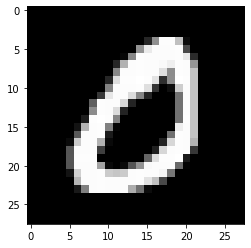

In [19]:
digit = train_and_validation_data[0] #use the scaled data to see what actually is trained on
plt.figure(0)
plt.imshow(digit.reshape(28, 28), cmap=plt.cm.gray)
plt.show()

## 1. LogisticRegression (lr)

1. Run logistic regression on the train data with 'l2' regularization (a.k.a ridge regularization) with solver='liblinear'. <br> Use the validation data to choose the best regularization parameterr C out of the given list, with respect to accuracy measure.<br> plot the validation accuracy vs the powers array (scale of C) and print the best **Lambda** value: 1/c.
2. Train Logistic regression on the whole data (train+validation).
3. Given that the decision boundary is 0.5, plot the confusion matrix, and print the accuracy of the train data.
4. Given that the decision boundary is 0.5, plot the confusion matrix, and print the accuracy of the test data.
5. Plot one missclassified 8 digit and one missclassified 0 digit.

Comment: you may use the 'confusion_matrix' imported above from sklearn.metrics (not mandatory)

In [20]:
from sklearn.linear_model import LogisticRegression


# choose best C by logistic regrssion accuracy
powers = range(-10,0)
Cs = [10**p for p in powers] 
optimal_c = None
optimal_score = -1
scores = []

for c in Cs:
    model = LogisticRegression(C=c, penalty='l2', solver='liblinear')
    model.fit(X=train_data, y=train_labels)    
    score = model.score(validation_data, validation_labels)
    scores.append(score)    
    if score > optimal_score:
        optimal_score = score
        optimal_c = c



### Choosing the optimal `C`
Reminder: you need to print $\lambda = \frac{1}{c}$

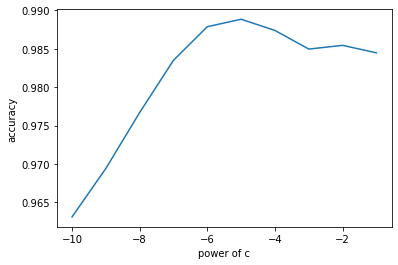

The optimal lambda is:  99999.99999999999 
( Best C: 1e-05 )


In [21]:
# plot and print best lambda
plt.plot(powers, scores)
plt.ylabel('accuracy')
plt.xlabel('power of c')
plt.show()

print("The optimal lambda is: ",1/optimal_c,
"\n( Best C:", optimal_c, ")")

### Using the lr best model (the one with the optimal C)
train on whole data and plot train, test confusion matrices

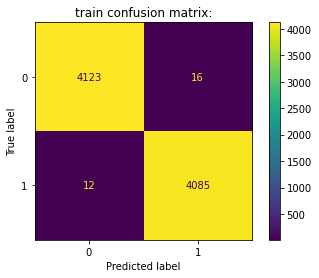

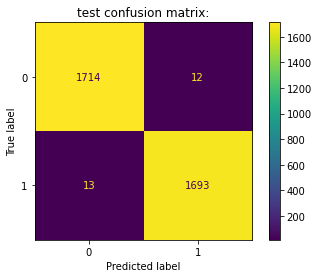

In [22]:
# train best model
model = LogisticRegression(C=optimal_c, penalty='l2', solver='liblinear')
model.fit(X=train_and_validation_data, y=train_and_validation_labels)

# plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
# conf_mat_train = confusion_matrix(y_true=train_and_validation_labels, y_pred=model.predict(train_data))
test_predictions = model.predict(test_data)
disp_train = ConfusionMatrixDisplay.from_predictions(y_true=train_labels, y_pred=model.predict(train_data))
disp_test = ConfusionMatrixDisplay.from_predictions(y_true=test_labels, y_pred=test_predictions)
for disp, title in ((disp_train, 'train'), (disp_test, 'test')):
    disp.ax_.set_title(f'{title} confusion matrix:')




### Plotting 2 missclassified digits

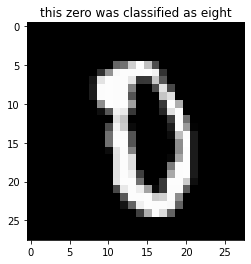

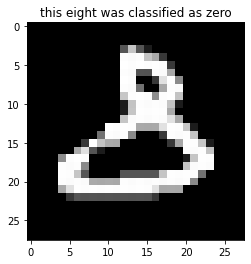

In [23]:
def plot_digit(digit_data, title):
    plt.title(title)
    plt.imshow(digit_data.reshape(28, 28), cmap=plt.cm.gray)    
    plt.show()

# plot misclassified 0
plot_digit(test_data[((test_labels == 0) & (test_predictions == 1)),:][0], "this zero was classified as eight")
# plot misclassified 8
plot_digit(test_data[((test_labels == 1) & (test_predictions == 0)),:][0], "this eight was classified as zero")


## 2. Multi Layer Perceptron (MLP)

1. Run MLP on the train data with 'l2' regularization (a.k.a ridge regularization) with the following parameters:<br>
   `hidden_layer_sizes=(25,), max_iter=225, solver='sgd', verbose=False, tol=1e-4, random_state=34,
   learning_rate_init=.001, alpha=?????`<br>
   The alpha parameter is the 'l2' coefficient (regularization strength).<br>
   * Below you can find possible alpha values. Use the validation data to choose the best one with respect to the accuracy measure.<br>
   * plot the validation accuracy vs alpha values (use log scale if needed)
   * print the best alpha value.
2. Train Logistic regression on the whole data (train+validation).
3. Given that the decision boundary is 0.5, plot the confusion matrix, and print the accuracy of the train data.
4. Given that the decision boundary is 0.5, plot the confusion matrix, and print the accuracy of the test data.
5. Plot one missclassified 8 digit and one missclassified 0 digit.

*Comment1*: you may use the 'confusion_matrix' imported above from sklearn.metrics (not mandatory)<br>
*Comment2*: to see the loss convergence between epochs, you may use verbose=True. Just replace it back to False before submission.

In [24]:
from sklearn.neural_network import MLPClassifier
powers = range(-1,5)
alphas = [10**(p) for p in powers]
best_score = -1
best_alpha = None
scores = []

for a in alphas:
    model = MLPClassifier(hidden_layer_sizes=(25,), max_iter=225, solver='sgd',verbose=False,
                         tol=10**-4,random_state=34, learning_rate_init=0.001, alpha=a)
    model.fit(train_data, train_labels)
    score = model.score(X=validation_data, y=validation_labels)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_alpha = a
         





C:\Users\itayz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (225) reached and the optimization hasn't converged yet.
  warnings.warn(


### Choosing the optimal alpha

The optimal lambda is:  10


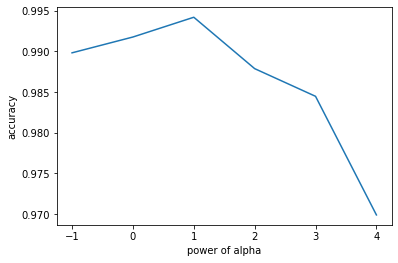

In [25]:
alpha_opt_mlp = best_alpha
print("The optimal lambda is: ", alpha_opt_mlp)
plt.plot(powers, scores)
plt.ylabel('accuracy')
plt.xlabel('power of alpha')
plt.show()


### Using the best MLP model
train on whole data and plot train, test confusion matrices

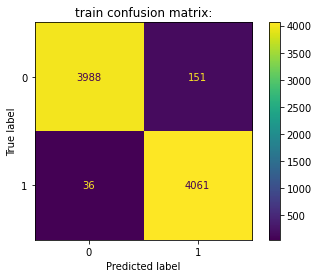

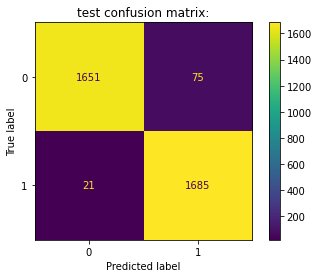

In [26]:
model.fit(train_and_validation_data, train_and_validation_labels)
test_preds = model.predict(test_data)
train_preds = model.predict(train_data)
disp_train = ConfusionMatrixDisplay.from_predictions(y_true=train_labels, y_pred=train_preds)
disp_test = ConfusionMatrixDisplay.from_predictions(y_true=test_labels, y_pred=test_preds)
for disp, title in ((disp_train, 'train'), (disp_test, 'test')):
    disp.ax_.set_title(f'{title} confusion matrix:')

### plotting 2 missclassified digits

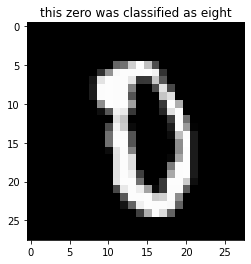

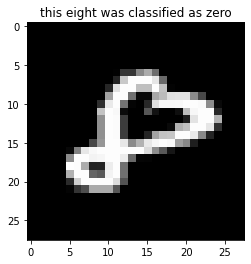

In [27]:
# plot misclassified 0
plot_digit(test_data[((test_labels == 0) & (test_preds == 1)),:][0], "this zero was classified as eight")
# plot misclassified 8
plot_digit(test_data[((test_labels == 1) & (test_preds == 0)),:][0], "this eight was classified as zero")
